In [1]:
import pickle
import time

import numpy as np
from gep_config_parser import *
from data_wrangling import dataframe_to_dict

from primal_dual_refactored import PrimalDualTrainer
from gep_problem_refactored import GEPProblemSet
from gep_problem_operational import GEPOperationalProblemSet
from gep_main import run_model as run_Gurobi
from gep_main import run_model_no_bounds as run_Gurobi_no_bounds
from get_gurobi_vars import OptValueExtractor
import sys
import torch

import pyomo as pyo

CONFIG_FILE_NAME        = "config.toml"
VISUALIZATION_FILE_NAME = "visualization.toml"


SCALE_FACTORS = {
    "pDemand": 1/1000,  # MW -> GW
    "pGenAva": 1,       # Don't scale
    "pVOLL": 1,         # kEUR/MWh -> mEUR/GWh
    "pWeight": 1,       # Don't scale
    "pRamping": 1,      # Don't scale
    "pInvCost": 1,      # kEUR/MW -> mEUR/GW
    "pVarCost": 1,      # kEUR/MWh -> mEUR/GWh
    "pUnitCap": 1/1000, # MW -> GW
    "pExpCap": 1/1000,  # MW -> GW
    "pImpCap": 1/1000,  # MW -> GW
}


## Step 1: parse the input data
print("Parsing the config file")

data = parse_config(CONFIG_FILE_NAME)
experiment = data["experiment"]
outputs_config = data["outputs_config"]

def scale_dict(data_dict, scale_factor):
    return {key: value * scale_factor for key, value in data_dict.items()}


def prep_data(inputs, scale_input=False, train=0.8, valid=0.1, test=0.1, scale=False, sample_duration=12, constant_gen_inv=False):
    print("Wrangling the input data")

    # Extract sets
    T = inputs["times"] # [1, 2, 3, ... 8760] ---> 8760
    G = inputs["generators"] # [('Country1', 'EnergySource1'), ...] ---> 107
    L = inputs["transmission_lines"] # [('Country1', 'Country2'), ...] ---> 44
    N = inputs["nodes"] # ['Country1', 'Country2', ...] ---> 20

    ### SET UP CUSTOM CONFIG ###
    # N = ['BEL', 'FRA', 'GER', 'NED'] # 4 nodes
    # N = ['BEL', 'GER', 'NED'] # 3 nodes
    N = ['BEL', 'GER'] # 2 nodes
    # G = [('BEL', 'SunPV'), ('GER', 'SunPV'), ('NED', 'SunPV')] # 3 generators
    # G = [('BEL', 'SunPV'), ('BEL', 'Gas'), ('BEL', 'Oil'), ('BEL', 'WindOn'), ('BEL', 'WindOff'),
    #      ('GER', 'SunPV'), ('GER', 'Coal'), ('GER', 'Gas'), ('GER', 'Oil'), ('GER', 'WindOn'), ('GER', 'WindOff'),
    #      ('NED', 'SunPV'), ('NED', 'WindOn'), ('NED', 'WindOff')] # All generators
    # G = [('BEL', 'SunPV'), ('BEL', 'Gas'),
        #  ('GER', 'SunPV'), ('GER', 'Gas'),
        #  ('NED', 'SunPV')] # Only sun and gas
    G = [('BEL', 'Gas'),
         ('GER', 'Gas'),] # Only gas
    # L = [('BEL', 'FRA'), ('BEL', 'GER'), ('BEL', 'NED'), ('GER', 'FRA'), ('GER', 'NED')] # 5 lines
    # L = [('BEL', 'GER'), ('BEL', 'NED'), ('GER', 'NED')] # 3 lines
    L = [('BEL', 'GER')] # 2 lines

    # Extract time series data
    pDemand = dataframe_to_dict(
        inputs["demand_data"],
        keys=["Country", "Time"],
        value="Demand_MW"
    )
    
    pGenAva = dataframe_to_dict(
        inputs["generation_availability_data"],
        keys=["Country", "Technology", "Time"],
        value="Availability_pu"
    )

    # Extract scalar parameters
    pVOLL = inputs["value_of_lost_load"]

    # WOP
    # Scale inversely proportional to times (T)
    pWeight = inputs["representative_period_weight"] / (sample_duration / 8760)

    pRamping = inputs["ramping_value"]

    # Extract generator parameters
    pInvCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="InvCost_kEUR_MW_year"
    )

    pVarCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="VarCost_kEUR_per_MWh"
    )

    pUnitCap = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="UnitCap_MW"
    )

    # Extract line parameters
    pExpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ExpCap_MW"
    )

    pImpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ImpCap_MW"
    )

    if scale:
        pDemand = scale_dict(pDemand, SCALE_FACTORS["pDemand"])
        pGenAva = scale_dict(pGenAva, SCALE_FACTORS["pGenAva"])
        pVOLL *= SCALE_FACTORS["pVOLL"]
        pWeight *= SCALE_FACTORS["pWeight"]
        pRamping *= SCALE_FACTORS["pRamping"]
        pInvCost = scale_dict(pInvCost, SCALE_FACTORS["pInvCost"])
        pVarCost = scale_dict(pVarCost, SCALE_FACTORS["pVarCost"])
        pUnitCap = scale_dict(pUnitCap, SCALE_FACTORS["pUnitCap"])
        pExpCap = scale_dict(pExpCap, SCALE_FACTORS["pExpCap"])
        pImpCap = scale_dict(pImpCap, SCALE_FACTORS["pImpCap"])


    # We need to sort the dictionaries for changing to tensors!
    pDemand = dict(sorted(pDemand.items()))
    pGenAva = dict(sorted(pGenAva.items()))
    pInvCost = dict(sorted(pInvCost.items()))
    pVarCost = dict(sorted(pVarCost.items()))
    pUnitCap = dict(sorted(pUnitCap.items()))
    pExpCap = dict(sorted(pExpCap.items()))
    pImpCap = dict(sorted(pImpCap.items()))


    print("Creating problem instance")
    if constant_gen_inv:
        data = GEPOperationalProblemSet(T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, sample_duration=sample_duration, train=train, valid=valid, test=test)
    else:
        data = GEPProblemSet(T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, sample_duration=sample_duration, train=train, valid=valid, test=test)

    return data

def run_PDL(data, args, save_dir, optimal_objective_train=None, optimal_objective_val=None):
    # Run PDL
    print("Training the PDL")
    trainer = PrimalDualTrainer(data, args, save_dir, optimal_objective_train=optimal_objective_train, optimal_objective_val=optimal_objective_val)
    primal_net, dual_net, stats = trainer.train_PDL()

if __name__ == "__main__":
    args = {
            # "K": 2,
            "K": 10,
            # "L": 1,
            "L": 1000,
            # "L": 2000,
            "tau": 0.8,
            # "rho": 0.1,
            # "rho": 0.2,
            "rho": 0.5,
            # "rho": 0.1,
            # "rho_max": 10,
            "rho_max": 5000,
            # "rho_max": 100,
            # "rho_max": sys.maxsize * 2 + 1,
            "alpha": 10,
            # "alpha": 2,
            "batch_size": 100,
            "hidden_sizes": [500, 500],
            # "hidden_sizes": [1000, 1000, 1000, 1000],
            # "hidden_sizes": [500, 500, 500, 500],
            # "hidden_size": 1000,
            # "primal_lr": 1e-4,
            "primal_lr": 1e-4,
            "dual_lr": 1e-4,
            # "primal_lr": 1e-5,
            # "dual_lr": 1e-5,
            # "decay": 0.99,
            "decay": 0.99,
            "patience": 10,
            "corrEps": 1e-4,
            "shuffle": False,
            "scale_input": False,
            "train": 0.002, # 1 sample
            "valid": 0.002,
            "test": 0.996,
            # "train": 0.004, # 2 samples
            # "valid": 0.004,
            # "test": 0.992,
            # "train": 0.8,
            # "valid": 0.1,
            # "test": 0.1
            # "train": 0.004,
            # "valid": 0.004,
            # "test": 0.992,
            "sample_duration": 12,
            "operational": True,
            # "train": 0.02,
            # "valid": 0.02,
            # "test": 0.96,
    }

    # Train the model:
    for i, experiment_instance in enumerate(experiment["experiments"]):
        # Setup output dataframe
        df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

        for j in range(experiment["repeats"]):
            # Run one experiment for j repeats
            run_name = f"refactored_train:{args['train']}_rho:{args['rho']}_rhomax:{args['rho_max']}_alpha:{args['alpha']}_L:{args['alpha']}_scaled:{args['scale_input']}"
            save_dir = os.path.join('outputs', 'PDL',
                run_name + "-" + str(time.time()).replace('.', '-'))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            with open(os.path.join(save_dir, 'args.dict'), 'wb') as f:
                pickle.dump(args, f)
            
            # Prep proble data:
            data = prep_data(experiment_instance, train=args["train"], valid=args["valid"], test=args["test"], sample_duration=args["sample_duration"], constant_gen_inv=args["operational"])

            # Run PDL
            # run_PDL(data, args, save_dir)




Running on cpu
Parsing the config file
Initializing the solver
Using Gurobi
Parsing the config file
Wrangling the input data
Creating problem instance
Populating ineq constraints
Populating eq constraints
Creating objective coefficients
Creating input for NN: X
Size of train set: 1
Size of val set: 1
Size of test set: 728


In [2]:
def scale_b_and_adjust_A_c(A, b, c):
    # Step 1: Compute the norm of b
    b_norm = np.linalg.norm(b, ord=2)
    
    # Step 2: Scale b to have magnitude 1
    b_scaled = b / b_norm
    
    # Step 3: Scale rows of A accordingly
    A_scaled = A / b_norm
    
    # Step 4: Scale c to preserve consistency
    c_scaled = c * b_norm

    scale_term = b_norm
    
    return A_scaled, b_scaled, c_scaled, scale_term


def recover_original(A_scaled, b_scaled, c_scaled, scale_term):
    A_unscaled = A_scaled * scale_term
    b_unscaled = b_scaled * scale_term
    c_unscaled = c_scaled / scale_term

    return A_unscaled, b_unscaled, c_unscaled


eq_cm = data.eq_cm[0]
ineq_cm = data.ineq_cm[0]
eq_rhs = data.eq_rhs[0]
ineq_rhs = data.ineq_rhs[0]
c_original = data.obj_coeff

print(eq_cm.shape)
print(ineq_cm.shape)
print(eq_rhs.shape)
print(ineq_rhs.shape)
print(c_original.shape)


A_original = torch.cat([eq_cm, ineq_cm], dim=0)
b_original = torch.cat([eq_rhs, ineq_rhs])

print(A_original.shape)
print(b_original.shape)

A_scaled, b_scaled, c_scaled, scale_term = scale_b_and_adjust_A_c(A_original, b_original, c_original)

A_unscaled, b_unscaled, c_unscaled = recover_original(A_scaled, b_scaled, c_scaled, scale_term)

print((A_original == A_unscaled).all())
print(torch.allclose(b_original, b_unscaled, atol=1e-12))
print((c_original == c_unscaled).all())

print((b_original - b_unscaled).tolist())

torch.Size([24, 60])
torch.Size([164, 60])
torch.Size([24])
torch.Size([164])
torch.Size([60])
torch.Size([188, 60])
torch.Size([188])
tensor(True)
True
tensor(True)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.637978807091713e-12, -4.547473508864641e-13, 3.637978807091713e-12, -4.547473508864641e-13, 0.0, 0.0, 3.637978807091713e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 2.2737367544323206e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

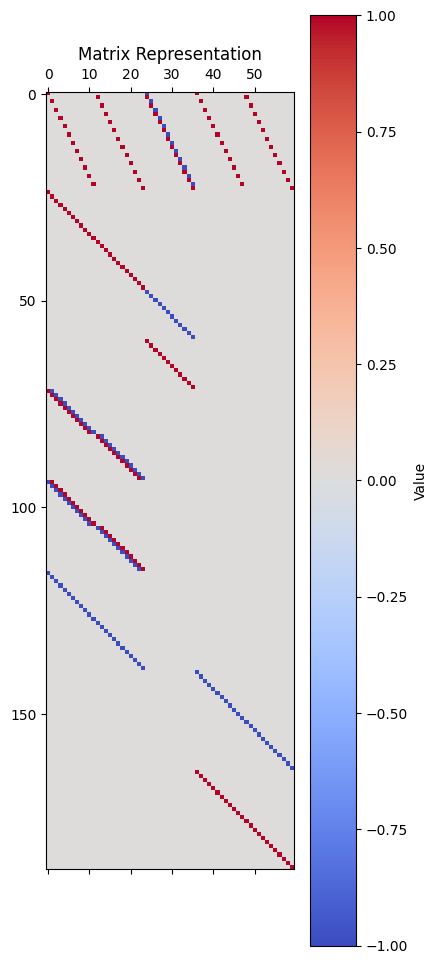

tensor(1.)


In [3]:
import matplotlib.pyplot as plt
plt.matshow(A_original, cmap='coolwarm')  # 'coolwarm' is another color map
plt.colorbar(label="Value")
plt.title("Matrix Representation")
plt.show()

print(eq_cm.max())

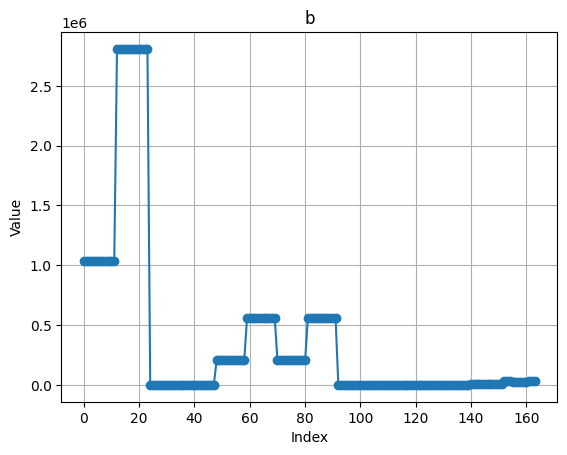

In [4]:
plt.plot(ineq_rhs, marker='o')
plt.title("b")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid()
plt.show()

In [13]:
print(data.neq)
pDemand = data.X[0, :data.neq]

print(len(pDemand))
print(pDemand)

24
24
tensor([ 5336.3813, 33061.6701,  4884.6334, 31449.1851,  4489.7215, 29727.8246,
         4159.4850, 28264.6022,  3890.9841, 27576.0331,  3778.2921, 26813.5104,
         3817.4894, 25294.1990,  3566.6272, 25573.2655,  3586.2258, 26287.9487,
         3675.3995, 28726.0943,  3902.7433, 31548.1868,  4151.6456, 34825.7683])
